In [200]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
data = xr.open_dataset("./data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
#data = xr.open_dataset("./data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data_old = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("./data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]

#14400 orginial size
data = data[:500, :, :]

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

data = ut.apply_mask(mask, data)
print("Data : {} + shape {}".format(data, data.shape))

data_anomalies = ut.calculate_monthly_anomalies(data)
print("Month mean : {} + shape : {}".format(data_anomalies, data_anomalies.shape))

data_cropped =ut.crop_xarray(data_anomalies)
print("Data cropped : {} + shape : {}".format(data_cropped, data_cropped.shape))


pca_10 = ut.SpatioTemporalPCA(data_cropped, n_components=20)
#pca_10 = ut.SpatioTemporalPCA(data_anomalies, n_components=20)
eof_10 = pca_10.eofs()
pc_10 = pca_10.principal_components()

Data shape: (500, 192, 288)
Data : <xarray.DataArray 'ts' (time: 500, lat: 192, lon: 288)>
[27648000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * time     (time) object 0001-01-15 12:00:00 ... 0042-08-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          K
    variable_id:    ts
Data : <xarray.DataArray (lat: 192, lon: 288, time: 500)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan, 

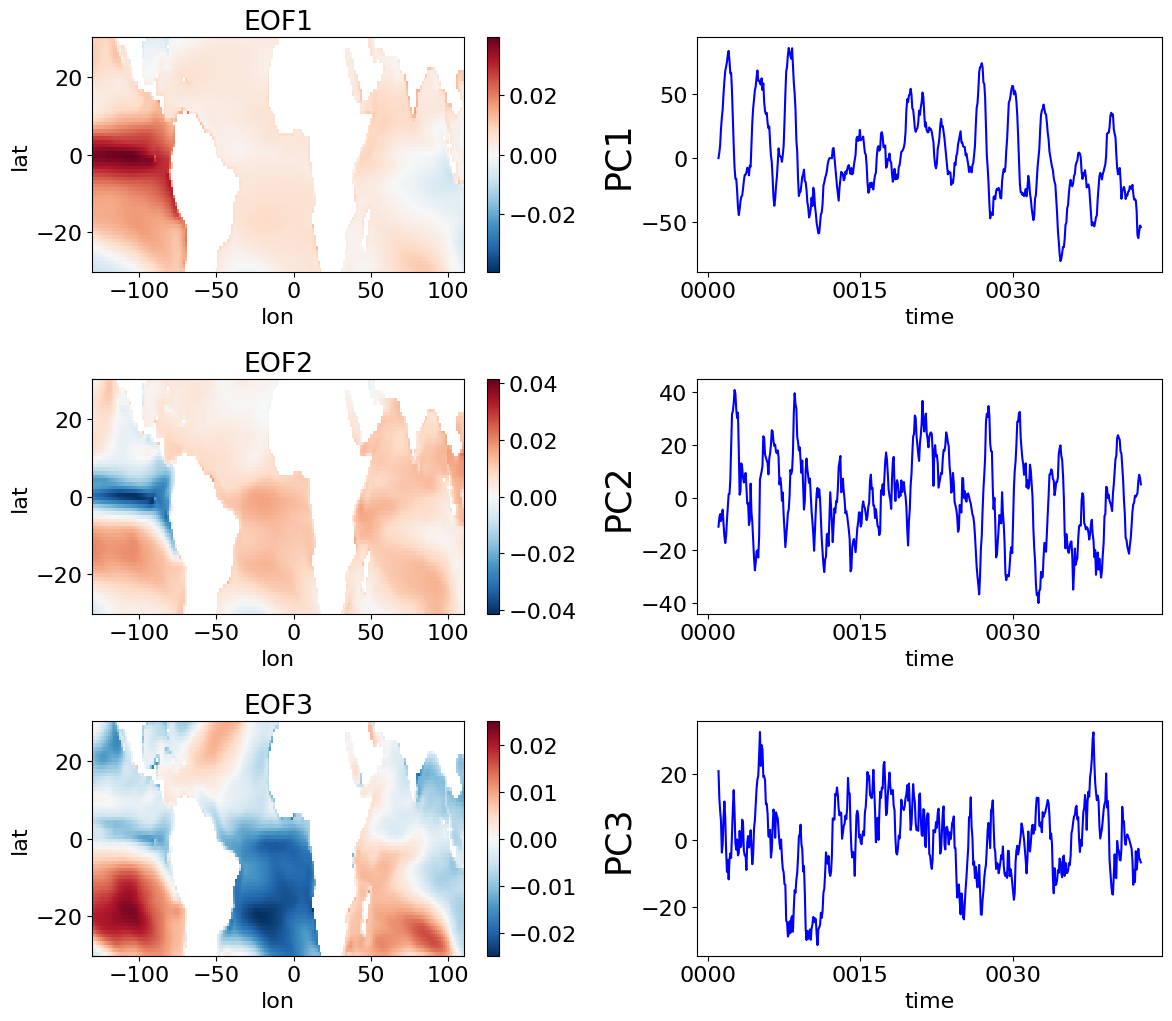

In [202]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig = plt.figure(figsize=(2 * 6, 3.5 * number_of_plots))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    ax = fig.add_subplot(number_of_plots, 2, 2*i+1)
    eof_10[i].plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(number_of_plots, 2, 2*i + 2)
    pc_10.isel(eof=i).plot(ax=ax, color="blue")
    ax.set_ylabel(f"PC{i+1}", fontsize=25)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_piControl.png', format='png')
plt.show()

In [203]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

eigenvalues, _, _ = ut.matrix_decomposition(model.green_function)
t_decay = [abs(-(1/np.log(eigenvalue.real))) for eigenvalue in eigenvalues]

print("Eigenvalues : min {} + max {}".format(min(eigenvalues), max(eigenvalues)))
print("T-decay : min {} + max {}".format(min(t_decay), max(t_decay)))
#print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Frobenius norm: 1.3557024002075195
Eigenvalues : min (0.5421960949897766-0.06608450412750244j) + max (0.9302968978881836+0.1483127623796463j)
T-decay : min 1.6336464716533805 + max 13.840543352095688


In [204]:
# Simulate stochastic differential equation
x_input = data_train.isel(time=0)
times = x_input['time']
x = x_input.data

lim_integration, times_ = model.noise_integration(x, timesteps=499, seed=10, num_comp=len(pc_10))

lim_integration = lim_integration.T
pc_10 = np.array(pc_10)
print("LIMMM : {} + next {} + next {}".format(lim_integration[0][:5], lim_integration[0][50], lim_integration[0][-3:]))
#print("LIMMM : {} + next {} + next {}".format(lim_integration[1][:5], lim_integration[1][50], lim_integration[1][-3:]))
#print("LIMMM : {} + next {} + next {}".format(lim_integration[2][:5], lim_integration[2][50], lim_integration[2][-3:]))
print("PCCC : {} + next {} + next {}".format(pc_10[0][:5], pc_10[0][50], pc_10[0][-3:] ))
#print("PCCC : {} + next {} + next {}".format(pc_10[1][:5], pc_10[1][50], pc_10[1][-3:]))
#print("PCCC : {} + next {} + next {}".format(pc_10[2][:5], pc_10[2][50], pc_10[2][-3:]))


#print("LIM integration : {} + shape {} + type {} ".format(lim_integration, lim_integration.shape, type(lim_integration)))
#print("PC  : {} + shape {} + type {} ".format(pc_10, pc_10.shape, type(pc_10)))

#print("LIM integration : {} + shape {} + type {} ".format(lim_integration_T[:5], lim_integration_T.shape, type(lim_integration_T)))

t_delta: 1.6211803752995166
LIMMM : [-0.20970838 15.98398991 45.49257492 49.8138058  64.5737148 ] + next -21.452098812478184 + next [12.99865954 24.92639294 19.13825307]
PCCC : [-0.20970838  4.0342665  10.009429   22.6816     31.508465  ] + next 57.25449752807617 + next [-57.608074 -53.028046 -54.16682 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


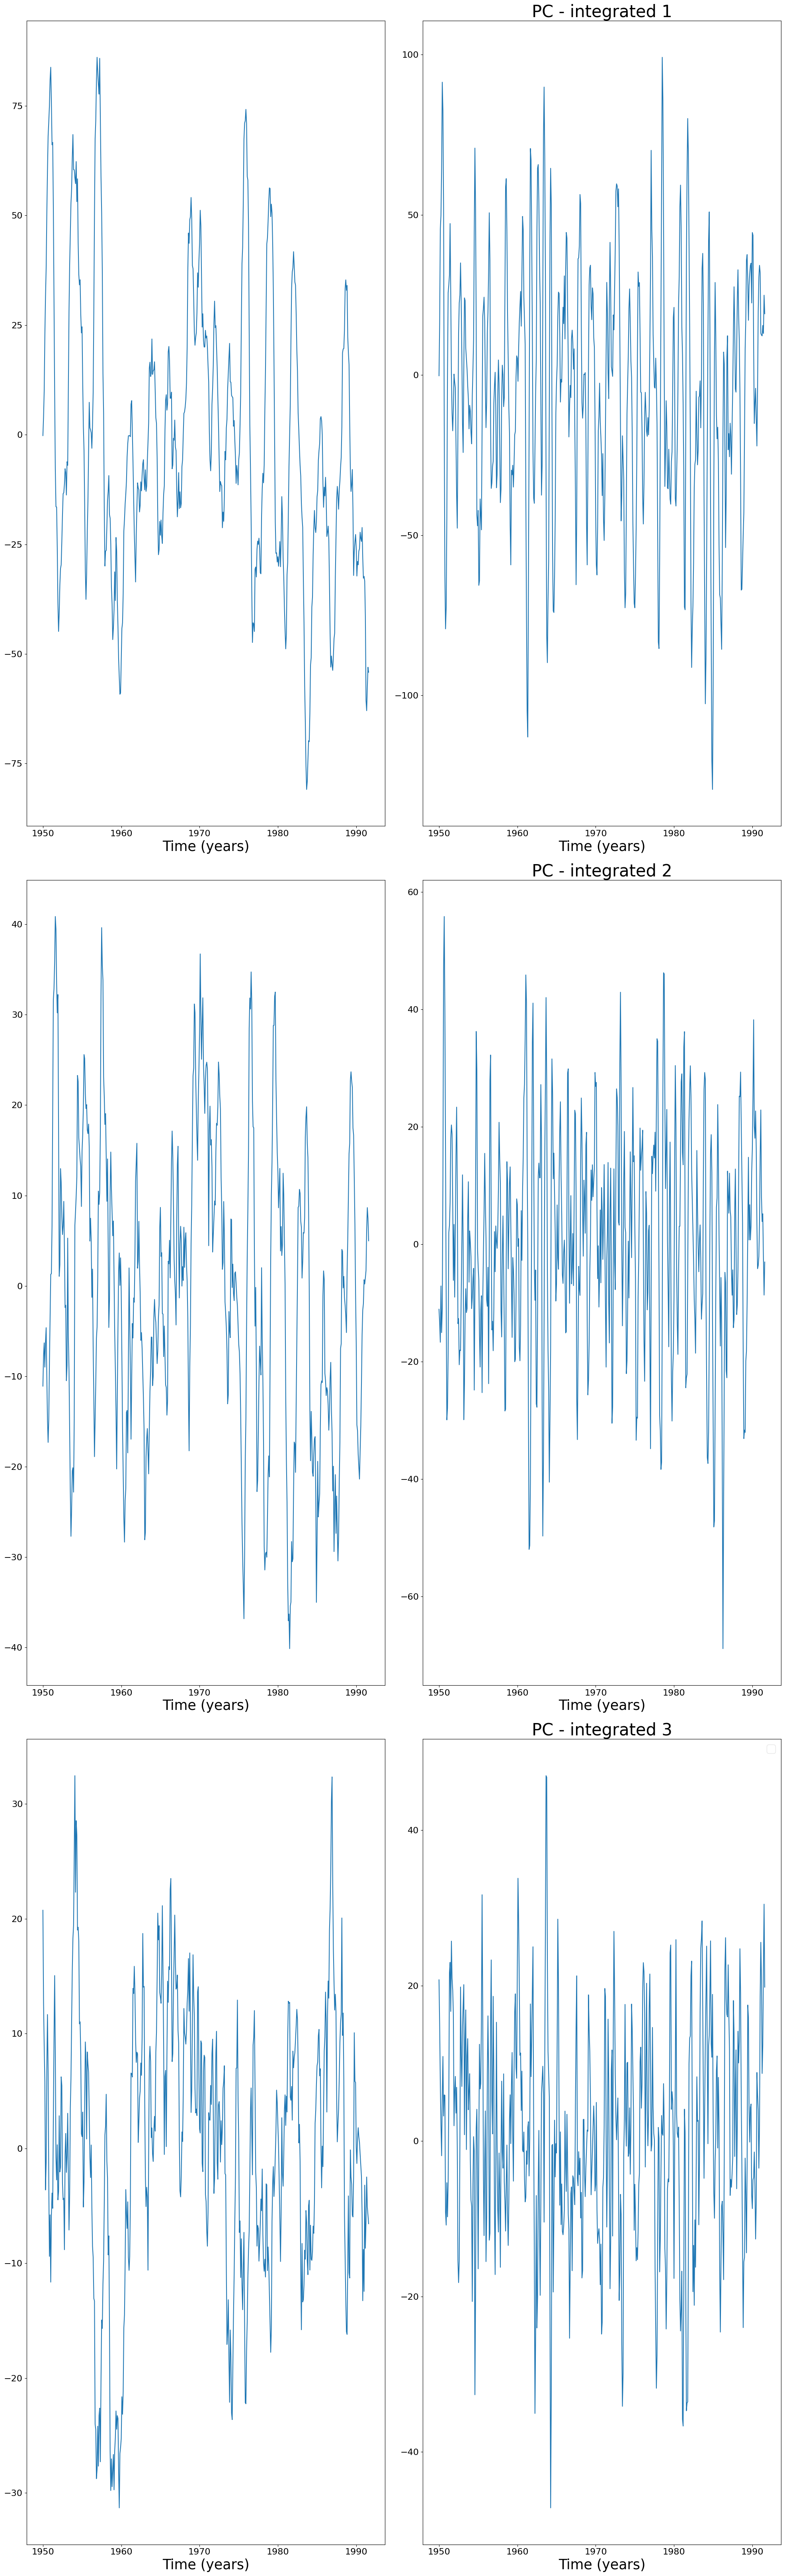

In [205]:
# Set the number of plots to 2
number_of_plots = 3
# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(20, 65))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,1].set_title("PC - integrated {}".format(i + 1), fontsize=30)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950

    # Plot PC with time on x-axis in years
    axs[i,0].plot(time_years, pc_10[i][:500])
    axs[i,0].set_xlabel("Time (years)", fontsize=25)

    # Plot PC with time on x-axis in years for integrated data
    axs[i,1].plot(time_years, lim_integration[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=25)



plt.legend(loc="upper right", fontsize=20)
# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
#fig.savefig('./plots/svg/EOFS_timeseries_RdBu_r_piControl_.svg', format='svg')
#fig.savefig('./plots/png/EOFS_timeseries_RdBu_r_piControl_.png', format='png')
plt.show()